In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1457498, 828)
(1457498, 8)
validation
(253674, 828)
(253674, 8)
test
(143060, 828)
(143060, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/146 [..............................] - ETA: 4:13 - loss: 2.2306 - STD: 0.0728 - MAE: 0.2181

  3/146 [..............................] - ETA: 3s - loss: 2.1350 - STD: 0.0591 - MAE: 0.2167  

  5/146 [>.............................] - ETA: 3s - loss: 2.1087 - STD: 0.0516 - MAE: 0.2166

  7/146 [>.............................] - ETA: 3s - loss: 2.1024 - STD: 0.0480 - MAE: 0.2168

 10/146 [=>............................] - ETA: 3s - loss: 2.0918 - STD: 0.0447 - MAE: 0.2168

 12/146 [=>............................] - ETA: 3s - loss: 2.0842 - STD: 0.0433 - MAE: 0.2167

 14/146 [=>............................] - ETA: 3s - loss: 2.0783 - STD: 0.0421 - MAE: 0.2166

 16/146 [==>...........................] - ETA: 3s - loss: 2.0740 - STD: 0.0412 - MAE: 0.2165

 18/146 [==>...........................] - ETA: 3s - loss: 2.0697 - STD: 0.0406 - MAE: 0.2165

 20/146 [===>..........................] - ETA: 3s - loss: 2.0651 - STD: 0.0401 - MAE: 0.2163

 22/146 [===>..........................] - ETA: 3s - loss: 2.0590 - STD: 0.0397 - MAE: 0.2162

 24/146 [===>..........................] - ETA: 8s - loss: 2.0531 - STD: 0.0396 - MAE: 0.2160

 27/146 [====>.........................] - ETA: 7s - loss: 2.0412 - STD: 0.0403 - MAE: 0.2155

 30/146 [=====>........................] - ETA: 7s - loss: 2.0288 - STD: 0.0420 - MAE: 0.2149

 33/146 [=====>........................] - ETA: 6s - loss: 2.0148 - STD: 0.0444 - MAE: 0.2142

 36/146 [======>.......................] - ETA: 6s - loss: 2.0012 - STD: 0.0471 - MAE: 0.2134

 39/146 [=======>......................] - ETA: 5s - loss: 1.9870 - STD: 0.0494 - MAE: 0.2127

 42/146 [=======>......................] - ETA: 5s - loss: 1.9736 - STD: 0.0519 - MAE: 0.2120

 45/146 [========>.....................] - ETA: 4s - loss: 1.9606 - STD: 0.0542 - MAE: 0.2112

 48/146 [========>.....................] - ETA: 4s - loss: 1.9475 - STD: 0.0566 - MAE: 0.2105

 51/146 [=========>....................] - ETA: 4s - loss: 1.9340 - STD: 0.0589 - MAE: 0.2097

 54/146 [==========>...................] - ETA: 4s - loss: 1.9207 - STD: 0.0610 - MAE: 0.2089

 57/146 [==========>...................] - ETA: 3s - loss: 1.9070 - STD: 0.0633 - MAE: 0.2081

 60/146 [===========>..................] - ETA: 3s - loss: 1.8926 - STD: 0.0653 - MAE: 0.2073

 63/146 [===========>..................] - ETA: 3s - loss: 1.8776 - STD: 0.0673 - MAE: 0.2065

 66/146 [============>.................] - ETA: 3s - loss: 1.8620 - STD: 0.0695 - MAE: 0.2056

 69/146 [=============>................] - ETA: 3s - loss: 1.8457 - STD: 0.0717 - MAE: 0.2047

 72/146 [=============>................] - ETA: 2s - loss: 1.8295 - STD: 0.0739 - MAE: 0.2037

 75/146 [==============>...............] - ETA: 2s - loss: 1.8130 - STD: 0.0762 - MAE: 0.2027

 78/146 [===============>..............] - ETA: 2s - loss: 1.7967 - STD: 0.0785 - MAE: 0.2017

 81/146 [===============>..............] - ETA: 2s - loss: 1.7809 - STD: 0.0808 - MAE: 0.2007

 84/146 [================>.............] - ETA: 2s - loss: 1.7655 - STD: 0.0831 - MAE: 0.1996

 87/146 [================>.............] - ETA: 2s - loss: 1.7504 - STD: 0.0854 - MAE: 0.1986

 90/146 [=================>............] - ETA: 1s - loss: 1.7360 - STD: 0.0876 - MAE: 0.1975

 93/146 [==================>...........] - ETA: 1s - loss: 1.7221 - STD: 0.0899 - MAE: 0.1965

 96/146 [==================>...........] - ETA: 1s - loss: 1.7090 - STD: 0.0920 - MAE: 0.1956

 99/146 [===================>..........] - ETA: 1s - loss: 1.6962 - STD: 0.0940 - MAE: 0.1946

101/146 [===================>..........] - ETA: 1s - loss: 1.6880 - STD: 0.0954 - MAE: 0.1940

104/146 [====================>.........] - ETA: 1s - loss: 1.6760 - STD: 0.0974 - MAE: 0.1931

107/146 [====================>.........] - ETA: 1s - loss: 1.6643 - STD: 0.0993 - MAE: 0.1922

110/146 [=====================>........] - ETA: 1s - loss: 1.6531 - STD: 0.1011 - MAE: 0.1913

113/146 [======================>.......] - ETA: 1s - loss: 1.6423 - STD: 0.1029 - MAE: 0.1904

116/146 [======================>.......] - ETA: 0s - loss: 1.6318 - STD: 0.1046 - MAE: 0.1896

119/146 [=======================>......] - ETA: 0s - loss: 1.6220 - STD: 0.1063 - MAE: 0.1889

122/146 [========================>.....] - ETA: 0s - loss: 1.6124 - STD: 0.1079 - MAE: 0.1881

125/146 [========================>.....] - ETA: 0s - loss: 1.6031 - STD: 0.1094 - MAE: 0.1874

128/146 [=========================>....] - ETA: 0s - loss: 1.5943 - STD: 0.1108 - MAE: 0.1867

131/146 [=========================>....] - ETA: 0s - loss: 1.5859 - STD: 0.1123 - MAE: 0.1860

134/146 [==========================>...] - ETA: 0s - loss: 1.5780 - STD: 0.1136 - MAE: 0.1853

137/146 [===========================>..] - ETA: 0s - loss: 1.5700 - STD: 0.1149 - MAE: 0.1847

140/146 [===========================>..] - ETA: 0s - loss: 1.5625 - STD: 0.1162 - MAE: 0.1841

143/146 [============================>.] - ETA: 0s - loss: 1.5550 - STD: 0.1174 - MAE: 0.1835

146/146 [==============================] - ETA: 0s - loss: 1.5477 - STD: 0.1186 - MAE: 0.1829

146/146 [==============================] - 7s 38ms/step - loss: 1.5477 - STD: 0.1186 - MAE: 0.1829 - val_loss: 1.2003 - val_STD: 0.1768 - val_MAE: 0.1540


Epoch 2/10000


  1/146 [..............................] - ETA: 7s - loss: 1.2038 - STD: 0.1756 - MAE: 0.1549

  4/146 [..............................] - ETA: 3s - loss: 1.2020 - STD: 0.1760 - MAE: 0.1546

  7/146 [>.............................] - ETA: 3s - loss: 1.2006 - STD: 0.1765 - MAE: 0.1543

 10/146 [=>............................] - ETA: 3s - loss: 1.2020 - STD: 0.1769 - MAE: 0.1543

 13/146 [=>............................] - ETA: 3s - loss: 1.2018 - STD: 0.1769 - MAE: 0.1543

 16/146 [==>...........................] - ETA: 2s - loss: 1.1983 - STD: 0.1771 - MAE: 0.1540

 19/146 [==>...........................] - ETA: 2s - loss: 1.1960 - STD: 0.1774 - MAE: 0.1538

 22/146 [===>..........................] - ETA: 2s - loss: 1.1939 - STD: 0.1779 - MAE: 0.1535

 25/146 [====>.........................] - ETA: 2s - loss: 1.1917 - STD: 0.1781 - MAE: 0.1534

 28/146 [====>.........................] - ETA: 2s - loss: 1.1911 - STD: 0.1783 - MAE: 0.1533

 31/146 [=====>........................] - ETA: 2s - loss: 1.1896 - STD: 0.1786 - MAE: 0.1531

 34/146 [=====>........................] - ETA: 2s - loss: 1.1893 - STD: 0.1787 - MAE: 0.1530

 37/146 [======>.......................] - ETA: 2s - loss: 1.1884 - STD: 0.1789 - MAE: 0.1529

 40/146 [=======>......................] - ETA: 2s - loss: 1.1878 - STD: 0.1790 - MAE: 0.1529

 43/146 [=======>......................] - ETA: 2s - loss: 1.1869 - STD: 0.1792 - MAE: 0.1528

 46/146 [========>.....................] - ETA: 2s - loss: 1.1860 - STD: 0.1795 - MAE: 0.1527

 49/146 [=========>....................] - ETA: 2s - loss: 1.1859 - STD: 0.1797 - MAE: 0.1526

 52/146 [=========>....................] - ETA: 2s - loss: 1.1849 - STD: 0.1798 - MAE: 0.1525

 55/146 [==========>...................] - ETA: 2s - loss: 1.1840 - STD: 0.1799 - MAE: 0.1524

 58/146 [==========>...................] - ETA: 1s - loss: 1.1831 - STD: 0.1801 - MAE: 0.1523

 61/146 [===========>..................] - ETA: 1s - loss: 1.1818 - STD: 0.1803 - MAE: 0.1522

 64/146 [============>.................] - ETA: 1s - loss: 1.1806 - STD: 0.1804 - MAE: 0.1521

 67/146 [============>.................] - ETA: 1s - loss: 1.1799 - STD: 0.1805 - MAE: 0.1520

 70/146 [=============>................] - ETA: 1s - loss: 1.1791 - STD: 0.1807 - MAE: 0.1519

 73/146 [==============>...............] - ETA: 1s - loss: 1.1779 - STD: 0.1809 - MAE: 0.1518

 76/146 [==============>...............] - ETA: 1s - loss: 1.1768 - STD: 0.1810 - MAE: 0.1516

 79/146 [===============>..............] - ETA: 1s - loss: 1.1754 - STD: 0.1812 - MAE: 0.1515

 82/146 [===============>..............] - ETA: 1s - loss: 1.1744 - STD: 0.1814 - MAE: 0.1514

 85/146 [================>.............] - ETA: 1s - loss: 1.1735 - STD: 0.1815 - MAE: 0.1513

 88/146 [=================>............] - ETA: 1s - loss: 1.1723 - STD: 0.1817 - MAE: 0.1512

 91/146 [=================>............] - ETA: 1s - loss: 1.1710 - STD: 0.1818 - MAE: 0.1511

 94/146 [==================>...........] - ETA: 1s - loss: 1.1699 - STD: 0.1819 - MAE: 0.1510

 97/146 [==================>...........] - ETA: 1s - loss: 1.1689 - STD: 0.1821 - MAE: 0.1509

100/146 [===================>..........] - ETA: 1s - loss: 1.1677 - STD: 0.1823 - MAE: 0.1507

103/146 [====================>.........] - ETA: 0s - loss: 1.1663 - STD: 0.1824 - MAE: 0.1506

106/146 [====================>.........] - ETA: 0s - loss: 1.1653 - STD: 0.1826 - MAE: 0.1505

109/146 [=====================>........] - ETA: 0s - loss: 1.1645 - STD: 0.1827 - MAE: 0.1504

112/146 [======================>.......] - ETA: 0s - loss: 1.1636 - STD: 0.1829 - MAE: 0.1503

115/146 [======================>.......] - ETA: 0s - loss: 1.1623 - STD: 0.1830 - MAE: 0.1502

118/146 [=======================>......] - ETA: 0s - loss: 1.1611 - STD: 0.1832 - MAE: 0.1501

121/146 [=======================>......] - ETA: 0s - loss: 1.1605 - STD: 0.1833 - MAE: 0.1500

124/146 [========================>.....] - ETA: 0s - loss: 1.1595 - STD: 0.1835 - MAE: 0.1499

127/146 [=========================>....] - ETA: 0s - loss: 1.1586 - STD: 0.1836 - MAE: 0.1498

130/146 [=========================>....] - ETA: 0s - loss: 1.1577 - STD: 0.1837 - MAE: 0.1497

133/146 [==========================>...] - ETA: 0s - loss: 1.1568 - STD: 0.1839 - MAE: 0.1496

136/146 [==========================>...] - ETA: 0s - loss: 1.1560 - STD: 0.1840 - MAE: 0.1495

139/146 [===========================>..] - ETA: 0s - loss: 1.1550 - STD: 0.1842 - MAE: 0.1494

142/146 [============================>.] - ETA: 0s - loss: 1.1545 - STD: 0.1842 - MAE: 0.1494

145/146 [============================>.] - ETA: 0s - loss: 1.1537 - STD: 0.1844 - MAE: 0.1493

146/146 [==============================] - 4s 26ms/step - loss: 1.1534 - STD: 0.1844 - MAE: 0.1493 - val_loss: 1.1571 - val_STD: 0.1928 - val_MAE: 0.1458


Epoch 3/10000


  1/146 [..............................] - ETA: 7s - loss: 1.1001 - STD: 0.1913 - MAE: 0.1442

  4/146 [..............................] - ETA: 3s - loss: 1.1013 - STD: 0.1912 - MAE: 0.1441

  7/146 [>.............................] - ETA: 3s - loss: 1.1049 - STD: 0.1908 - MAE: 0.1444

 10/146 [=>............................] - ETA: 3s - loss: 1.1005 - STD: 0.1908 - MAE: 0.1442

 13/146 [=>............................] - ETA: 3s - loss: 1.0990 - STD: 0.1910 - MAE: 0.1440

 16/146 [==>...........................] - ETA: 2s - loss: 1.1002 - STD: 0.1912 - MAE: 0.1440

 19/146 [==>...........................] - ETA: 2s - loss: 1.0998 - STD: 0.1915 - MAE: 0.1439

 22/146 [===>..........................] - ETA: 2s - loss: 1.1006 - STD: 0.1916 - MAE: 0.1438

 25/146 [====>.........................] - ETA: 2s - loss: 1.1013 - STD: 0.1916 - MAE: 0.1439

 28/146 [====>.........................] - ETA: 2s - loss: 1.1006 - STD: 0.1918 - MAE: 0.1438

 31/146 [=====>........................] - ETA: 2s - loss: 1.1012 - STD: 0.1918 - MAE: 0.1438

 34/146 [=====>........................] - ETA: 2s - loss: 1.0997 - STD: 0.1920 - MAE: 0.1436

 37/146 [======>.......................] - ETA: 2s - loss: 1.0986 - STD: 0.1921 - MAE: 0.1435

 40/146 [=======>......................] - ETA: 2s - loss: 1.0975 - STD: 0.1922 - MAE: 0.1434

 43/146 [=======>......................] - ETA: 2s - loss: 1.0964 - STD: 0.1923 - MAE: 0.1433

 46/146 [========>.....................] - ETA: 2s - loss: 1.0951 - STD: 0.1924 - MAE: 0.1432

 49/146 [=========>....................] - ETA: 2s - loss: 1.0954 - STD: 0.1926 - MAE: 0.1432

 52/146 [=========>....................] - ETA: 2s - loss: 1.0946 - STD: 0.1926 - MAE: 0.1431

 55/146 [==========>...................] - ETA: 2s - loss: 1.0935 - STD: 0.1927 - MAE: 0.1430

 58/146 [==========>...................] - ETA: 1s - loss: 1.0922 - STD: 0.1928 - MAE: 0.1429

 61/146 [===========>..................] - ETA: 1s - loss: 1.0913 - STD: 0.1929 - MAE: 0.1428

 64/146 [============>.................] - ETA: 1s - loss: 1.0905 - STD: 0.1930 - MAE: 0.1427

 67/146 [============>.................] - ETA: 1s - loss: 1.0897 - STD: 0.1932 - MAE: 0.1426

 70/146 [=============>................] - ETA: 1s - loss: 1.0893 - STD: 0.1933 - MAE: 0.1426

 73/146 [==============>...............] - ETA: 1s - loss: 1.0888 - STD: 0.1934 - MAE: 0.1425

 76/146 [==============>...............] - ETA: 1s - loss: 1.0886 - STD: 0.1934 - MAE: 0.1425

 79/146 [===============>..............] - ETA: 1s - loss: 1.0879 - STD: 0.1936 - MAE: 0.1424

 82/146 [===============>..............] - ETA: 1s - loss: 1.0873 - STD: 0.1937 - MAE: 0.1423

 85/146 [================>.............] - ETA: 1s - loss: 1.0869 - STD: 0.1938 - MAE: 0.1422

 88/146 [=================>............] - ETA: 1s - loss: 1.0862 - STD: 0.1939 - MAE: 0.1422

 91/146 [=================>............] - ETA: 1s - loss: 1.0862 - STD: 0.1940 - MAE: 0.1422

 94/146 [==================>...........] - ETA: 1s - loss: 1.0858 - STD: 0.1941 - MAE: 0.1421

 97/146 [==================>...........] - ETA: 1s - loss: 1.0851 - STD: 0.1942 - MAE: 0.1420

100/146 [===================>..........] - ETA: 1s - loss: 1.0846 - STD: 0.1943 - MAE: 0.1420

103/146 [====================>.........] - ETA: 0s - loss: 1.0836 - STD: 0.1944 - MAE: 0.1419

106/146 [====================>.........] - ETA: 0s - loss: 1.0828 - STD: 0.1945 - MAE: 0.1418

109/146 [=====================>........] - ETA: 0s - loss: 1.0820 - STD: 0.1946 - MAE: 0.1417

112/146 [======================>.......] - ETA: 0s - loss: 1.0812 - STD: 0.1947 - MAE: 0.1416

115/146 [======================>.......] - ETA: 0s - loss: 1.0805 - STD: 0.1948 - MAE: 0.1415

118/146 [=======================>......] - ETA: 0s - loss: 1.0800 - STD: 0.1949 - MAE: 0.1415

121/146 [=======================>......] - ETA: 0s - loss: 1.0790 - STD: 0.1950 - MAE: 0.1414

124/146 [========================>.....] - ETA: 0s - loss: 1.0783 - STD: 0.1951 - MAE: 0.1413

127/146 [=========================>....] - ETA: 0s - loss: 1.0776 - STD: 0.1952 - MAE: 0.1412

130/146 [=========================>....] - ETA: 0s - loss: 1.0770 - STD: 0.1953 - MAE: 0.1411

133/146 [==========================>...] - ETA: 0s - loss: 1.0763 - STD: 0.1954 - MAE: 0.1410

136/146 [==========================>...] - ETA: 0s - loss: 1.0756 - STD: 0.1955 - MAE: 0.1410

139/146 [===========================>..] - ETA: 0s - loss: 1.0751 - STD: 0.1956 - MAE: 0.1409

142/146 [============================>.] - ETA: 0s - loss: 1.0744 - STD: 0.1957 - MAE: 0.1408

145/146 [============================>.] - ETA: 0s - loss: 1.0737 - STD: 0.1958 - MAE: 0.1407

146/146 [==============================] - 4s 26ms/step - loss: 1.0734 - STD: 0.1958 - MAE: 0.1407 - val_loss: 1.0857 - val_STD: 0.2003 - val_MAE: 0.1394


Epoch 4/10000


  1/146 [..............................] - ETA: 7s - loss: 1.0416 - STD: 0.1997 - MAE: 0.1374

  4/146 [..............................] - ETA: 3s - loss: 1.0400 - STD: 0.2008 - MAE: 0.1366

  7/146 [>.............................] - ETA: 3s - loss: 1.0393 - STD: 0.2008 - MAE: 0.1367

 10/146 [=>............................] - ETA: 3s - loss: 1.0401 - STD: 0.2011 - MAE: 0.1366

 13/146 [=>............................] - ETA: 2s - loss: 1.0377 - STD: 0.2012 - MAE: 0.1364

 16/146 [==>...........................] - ETA: 2s - loss: 1.0369 - STD: 0.2012 - MAE: 0.1364

 19/146 [==>...........................] - ETA: 2s - loss: 1.0368 - STD: 0.2014 - MAE: 0.1363

 22/146 [===>..........................] - ETA: 2s - loss: 1.0381 - STD: 0.2014 - MAE: 0.1364

 25/146 [====>.........................] - ETA: 2s - loss: 1.0377 - STD: 0.2014 - MAE: 0.1364

 28/146 [====>.........................] - ETA: 2s - loss: 1.0373 - STD: 0.2014 - MAE: 0.1364

 31/146 [=====>........................] - ETA: 2s - loss: 1.0367 - STD: 0.2015 - MAE: 0.1363

 34/146 [=====>........................] - ETA: 2s - loss: 1.0368 - STD: 0.2015 - MAE: 0.1363

 37/146 [======>.......................] - ETA: 2s - loss: 1.0356 - STD: 0.2015 - MAE: 0.1362

 40/146 [=======>......................] - ETA: 2s - loss: 1.0353 - STD: 0.2015 - MAE: 0.1362

 43/146 [=======>......................] - ETA: 2s - loss: 1.0353 - STD: 0.2016 - MAE: 0.1362

 46/146 [========>.....................] - ETA: 2s - loss: 1.0344 - STD: 0.2016 - MAE: 0.1361

 49/146 [=========>....................] - ETA: 2s - loss: 1.0342 - STD: 0.2017 - MAE: 0.1361

 52/146 [=========>....................] - ETA: 2s - loss: 1.0338 - STD: 0.2017 - MAE: 0.1360

 55/146 [==========>...................] - ETA: 2s - loss: 1.0324 - STD: 0.2018 - MAE: 0.1359

 58/146 [==========>...................] - ETA: 1s - loss: 1.0319 - STD: 0.2019 - MAE: 0.1359

 61/146 [===========>..................] - ETA: 1s - loss: 1.0310 - STD: 0.2020 - MAE: 0.1358

 64/146 [============>.................] - ETA: 1s - loss: 1.0311 - STD: 0.2021 - MAE: 0.1357

 67/146 [============>.................] - ETA: 1s - loss: 1.0303 - STD: 0.2022 - MAE: 0.1356

 70/146 [=============>................] - ETA: 1s - loss: 1.0308 - STD: 0.2022 - MAE: 0.1356

 73/146 [==============>...............] - ETA: 1s - loss: 1.0304 - STD: 0.2023 - MAE: 0.1356

 76/146 [==============>...............] - ETA: 1s - loss: 1.0297 - STD: 0.2023 - MAE: 0.1355

 79/146 [===============>..............] - ETA: 1s - loss: 1.0287 - STD: 0.2023 - MAE: 0.1355

 82/146 [===============>..............] - ETA: 1s - loss: 1.0286 - STD: 0.2024 - MAE: 0.1354

 85/146 [================>.............] - ETA: 1s - loss: 1.0277 - STD: 0.2025 - MAE: 0.1354

 88/146 [=================>............] - ETA: 1s - loss: 1.0269 - STD: 0.2026 - MAE: 0.1353

 91/146 [=================>............] - ETA: 1s - loss: 1.0264 - STD: 0.2027 - MAE: 0.1352

 94/146 [==================>...........] - ETA: 1s - loss: 1.0260 - STD: 0.2027 - MAE: 0.1352

 97/146 [==================>...........] - ETA: 1s - loss: 1.0255 - STD: 0.2028 - MAE: 0.1351

100/146 [===================>..........] - ETA: 1s - loss: 1.0249 - STD: 0.2029 - MAE: 0.1350

103/146 [====================>.........] - ETA: 0s - loss: 1.0243 - STD: 0.2030 - MAE: 0.1350

106/146 [====================>.........] - ETA: 0s - loss: 1.0239 - STD: 0.2031 - MAE: 0.1349

109/146 [=====================>........] - ETA: 0s - loss: 1.0235 - STD: 0.2031 - MAE: 0.1349

112/146 [======================>.......] - ETA: 0s - loss: 1.0229 - STD: 0.2032 - MAE: 0.1348

115/146 [======================>.......] - ETA: 0s - loss: 1.0226 - STD: 0.2032 - MAE: 0.1348

118/146 [=======================>......] - ETA: 0s - loss: 1.0220 - STD: 0.2033 - MAE: 0.1347

121/146 [=======================>......] - ETA: 0s - loss: 1.0211 - STD: 0.2034 - MAE: 0.1346

124/146 [========================>.....] - ETA: 0s - loss: 1.0204 - STD: 0.2034 - MAE: 0.1346

127/146 [=========================>....] - ETA: 0s - loss: 1.0200 - STD: 0.2035 - MAE: 0.1345

130/146 [=========================>....] - ETA: 0s - loss: 1.0194 - STD: 0.2036 - MAE: 0.1344

133/146 [==========================>...] - ETA: 0s - loss: 1.0192 - STD: 0.2037 - MAE: 0.1344

136/146 [==========================>...] - ETA: 0s - loss: 1.0189 - STD: 0.2038 - MAE: 0.1343

139/146 [===========================>..] - ETA: 0s - loss: 1.0184 - STD: 0.2038 - MAE: 0.1343

142/146 [============================>.] - ETA: 0s - loss: 1.0182 - STD: 0.2039 - MAE: 0.1342

145/146 [============================>.] - ETA: 0s - loss: 1.0175 - STD: 0.2040 - MAE: 0.1342

146/146 [==============================] - 4s 26ms/step - loss: 1.0173 - STD: 0.2040 - MAE: 0.1342 - val_loss: 1.0781 - val_STD: 0.2069 - val_MAE: 0.1367


Epoch 5/10000


  1/146 [..............................] - ETA: 7s - loss: 0.9852 - STD: 0.2062 - MAE: 0.1311

  4/146 [..............................] - ETA: 3s - loss: 0.9868 - STD: 0.2073 - MAE: 0.1309

  7/146 [>.............................] - ETA: 3s - loss: 0.9896 - STD: 0.2074 - MAE: 0.1310

 10/146 [=>............................] - ETA: 3s - loss: 0.9907 - STD: 0.2078 - MAE: 0.1310

 13/146 [=>............................] - ETA: 3s - loss: 0.9910 - STD: 0.2076 - MAE: 0.1311

 16/146 [==>...........................] - ETA: 2s - loss: 0.9893 - STD: 0.2077 - MAE: 0.1309

 19/146 [==>...........................] - ETA: 2s - loss: 0.9885 - STD: 0.2076 - MAE: 0.1309

 22/146 [===>..........................] - ETA: 2s - loss: 0.9867 - STD: 0.2077 - MAE: 0.1308

 25/146 [====>.........................] - ETA: 2s - loss: 0.9872 - STD: 0.2078 - MAE: 0.1308

 28/146 [====>.........................] - ETA: 2s - loss: 0.9865 - STD: 0.2078 - MAE: 0.1307

 31/146 [=====>........................] - ETA: 2s - loss: 0.9850 - STD: 0.2079 - MAE: 0.1306

 34/146 [=====>........................] - ETA: 2s - loss: 0.9838 - STD: 0.2080 - MAE: 0.1305

 37/146 [======>.......................] - ETA: 2s - loss: 0.9835 - STD: 0.2079 - MAE: 0.1305

 40/146 [=======>......................] - ETA: 2s - loss: 0.9832 - STD: 0.2080 - MAE: 0.1304

 43/146 [=======>......................] - ETA: 2s - loss: 0.9830 - STD: 0.2082 - MAE: 0.1304

 46/146 [========>.....................] - ETA: 2s - loss: 0.9818 - STD: 0.2082 - MAE: 0.1303

 49/146 [=========>....................] - ETA: 2s - loss: 0.9824 - STD: 0.2083 - MAE: 0.1303

 52/146 [=========>....................] - ETA: 2s - loss: 0.9817 - STD: 0.2083 - MAE: 0.1302

 55/146 [==========>...................] - ETA: 2s - loss: 0.9812 - STD: 0.2085 - MAE: 0.1301

 58/146 [==========>...................] - ETA: 1s - loss: 0.9812 - STD: 0.2085 - MAE: 0.1301

 61/146 [===========>..................] - ETA: 1s - loss: 0.9807 - STD: 0.2086 - MAE: 0.1300

 64/146 [============>.................] - ETA: 1s - loss: 0.9799 - STD: 0.2087 - MAE: 0.1299

 67/146 [============>.................] - ETA: 1s - loss: 0.9794 - STD: 0.2088 - MAE: 0.1299

 70/146 [=============>................] - ETA: 1s - loss: 0.9787 - STD: 0.2088 - MAE: 0.1298

 73/146 [==============>...............] - ETA: 1s - loss: 0.9783 - STD: 0.2089 - MAE: 0.1297

 76/146 [==============>...............] - ETA: 1s - loss: 0.9780 - STD: 0.2090 - MAE: 0.1297

 79/146 [===============>..............] - ETA: 1s - loss: 0.9777 - STD: 0.2091 - MAE: 0.1296

 82/146 [===============>..............] - ETA: 1s - loss: 0.9772 - STD: 0.2091 - MAE: 0.1296

 85/146 [================>.............] - ETA: 1s - loss: 0.9764 - STD: 0.2092 - MAE: 0.1295

 88/146 [=================>............] - ETA: 1s - loss: 0.9758 - STD: 0.2093 - MAE: 0.1294

 91/146 [=================>............] - ETA: 1s - loss: 0.9752 - STD: 0.2094 - MAE: 0.1294

 94/146 [==================>...........] - ETA: 1s - loss: 0.9745 - STD: 0.2094 - MAE: 0.1293

 97/146 [==================>...........] - ETA: 1s - loss: 0.9737 - STD: 0.2095 - MAE: 0.1292

100/146 [===================>..........] - ETA: 1s - loss: 0.9731 - STD: 0.2095 - MAE: 0.1292

103/146 [====================>.........] - ETA: 0s - loss: 0.9733 - STD: 0.2096 - MAE: 0.1291

106/146 [====================>.........] - ETA: 0s - loss: 0.9728 - STD: 0.2097 - MAE: 0.1291

109/146 [=====================>........] - ETA: 0s - loss: 0.9726 - STD: 0.2098 - MAE: 0.1290

112/146 [======================>.......] - ETA: 0s - loss: 0.9724 - STD: 0.2098 - MAE: 0.1290

115/146 [======================>.......] - ETA: 0s - loss: 0.9723 - STD: 0.2099 - MAE: 0.1290

118/146 [=======================>......] - ETA: 0s - loss: 0.9719 - STD: 0.2099 - MAE: 0.1289

121/146 [=======================>......] - ETA: 0s - loss: 0.9713 - STD: 0.2100 - MAE: 0.1289

124/146 [========================>.....] - ETA: 0s - loss: 0.9708 - STD: 0.2100 - MAE: 0.1288

127/146 [=========================>....] - ETA: 0s - loss: 0.9707 - STD: 0.2101 - MAE: 0.1288

130/146 [=========================>....] - ETA: 0s - loss: 0.9702 - STD: 0.2101 - MAE: 0.1287

133/146 [==========================>...] - ETA: 0s - loss: 0.9700 - STD: 0.2102 - MAE: 0.1287

136/146 [==========================>...] - ETA: 0s - loss: 0.9697 - STD: 0.2103 - MAE: 0.1287

139/146 [===========================>..] - ETA: 0s - loss: 0.9693 - STD: 0.2104 - MAE: 0.1286

142/146 [============================>.] - ETA: 0s - loss: 0.9690 - STD: 0.2104 - MAE: 0.1285

145/146 [============================>.] - ETA: 0s - loss: 0.9685 - STD: 0.2105 - MAE: 0.1285

146/146 [==============================] - 4s 26ms/step - loss: 0.9684 - STD: 0.2105 - MAE: 0.1285 - val_loss: 1.1019 - val_STD: 0.2129 - val_MAE: 0.1368


Epoch 6/10000


  1/146 [..............................] - ETA: 6s - loss: 0.9479 - STD: 0.2121 - MAE: 0.1269

  3/146 [..............................] - ETA: 3s - loss: 0.9524 - STD: 0.2127 - MAE: 0.1267

  6/146 [>.............................] - ETA: 3s - loss: 0.9453 - STD: 0.2129 - MAE: 0.1261

  9/146 [>.............................] - ETA: 3s - loss: 0.9461 - STD: 0.2128 - MAE: 0.1262

 12/146 [=>............................] - ETA: 3s - loss: 0.9444 - STD: 0.2130 - MAE: 0.1260

 15/146 [==>...........................] - ETA: 3s - loss: 0.9433 - STD: 0.2133 - MAE: 0.1258

 18/146 [==>...........................] - ETA: 2s - loss: 0.9430 - STD: 0.2136 - MAE: 0.1257

 21/146 [===>..........................] - ETA: 2s - loss: 0.9427 - STD: 0.2135 - MAE: 0.1257

 24/146 [===>..........................] - ETA: 2s - loss: 0.9427 - STD: 0.2136 - MAE: 0.1257

 27/146 [====>.........................] - ETA: 2s - loss: 0.9413 - STD: 0.2136 - MAE: 0.1256

 30/146 [=====>........................] - ETA: 2s - loss: 0.9402 - STD: 0.2137 - MAE: 0.1255

 33/146 [=====>........................] - ETA: 2s - loss: 0.9395 - STD: 0.2137 - MAE: 0.1254

 36/146 [======>.......................] - ETA: 2s - loss: 0.9380 - STD: 0.2138 - MAE: 0.1253

 39/146 [=======>......................] - ETA: 2s - loss: 0.9373 - STD: 0.2140 - MAE: 0.1252

 42/146 [=======>......................] - ETA: 2s - loss: 0.9412 - STD: 0.2142 - MAE: 0.1253

 45/146 [========>.....................] - ETA: 2s - loss: 0.9415 - STD: 0.2143 - MAE: 0.1253

 48/146 [========>.....................] - ETA: 2s - loss: 0.9412 - STD: 0.2144 - MAE: 0.1252

 51/146 [=========>....................] - ETA: 2s - loss: 0.9409 - STD: 0.2145 - MAE: 0.1251

 54/146 [==========>...................] - ETA: 2s - loss: 0.9401 - STD: 0.2146 - MAE: 0.1250

 57/146 [==========>...................] - ETA: 2s - loss: 0.9392 - STD: 0.2146 - MAE: 0.1250

 60/146 [===========>..................] - ETA: 1s - loss: 0.9383 - STD: 0.2146 - MAE: 0.1249

 63/146 [===========>..................] - ETA: 1s - loss: 0.9370 - STD: 0.2147 - MAE: 0.1248

 66/146 [============>.................] - ETA: 1s - loss: 0.9360 - STD: 0.2148 - MAE: 0.1247

 69/146 [=============>................] - ETA: 1s - loss: 0.9351 - STD: 0.2148 - MAE: 0.1246

 72/146 [=============>................] - ETA: 1s - loss: 0.9349 - STD: 0.2149 - MAE: 0.1246

 75/146 [==============>...............] - ETA: 1s - loss: 0.9344 - STD: 0.2150 - MAE: 0.1245

 78/146 [===============>..............] - ETA: 1s - loss: 0.9342 - STD: 0.2150 - MAE: 0.1245

 81/146 [===============>..............] - ETA: 1s - loss: 0.9336 - STD: 0.2151 - MAE: 0.1244

 84/146 [================>.............] - ETA: 1s - loss: 0.9327 - STD: 0.2152 - MAE: 0.1243

 87/146 [================>.............] - ETA: 1s - loss: 0.9323 - STD: 0.2153 - MAE: 0.1243

 90/146 [=================>............] - ETA: 1s - loss: 0.9317 - STD: 0.2153 - MAE: 0.1242

 93/146 [==================>...........] - ETA: 1s - loss: 0.9320 - STD: 0.2154 - MAE: 0.1242

 96/146 [==================>...........] - ETA: 1s - loss: 0.9321 - STD: 0.2155 - MAE: 0.1242

 99/146 [===================>..........] - ETA: 1s - loss: 0.9319 - STD: 0.2155 - MAE: 0.1241

102/146 [===================>..........] - ETA: 0s - loss: 0.9312 - STD: 0.2156 - MAE: 0.1241

105/146 [====================>.........] - ETA: 0s - loss: 0.9309 - STD: 0.2156 - MAE: 0.1240

108/146 [=====================>........] - ETA: 0s - loss: 0.9308 - STD: 0.2157 - MAE: 0.1240

111/146 [=====================>........] - ETA: 0s - loss: 0.9302 - STD: 0.2157 - MAE: 0.1239

114/146 [======================>.......] - ETA: 0s - loss: 0.9298 - STD: 0.2158 - MAE: 0.1239

117/146 [=======================>......] - ETA: 0s - loss: 0.9294 - STD: 0.2158 - MAE: 0.1238

120/146 [=======================>......] - ETA: 0s - loss: 0.9294 - STD: 0.2159 - MAE: 0.1238

123/146 [========================>.....] - ETA: 0s - loss: 0.9289 - STD: 0.2160 - MAE: 0.1238

126/146 [========================>.....] - ETA: 0s - loss: 0.9287 - STD: 0.2160 - MAE: 0.1237

129/146 [=========================>....] - ETA: 0s - loss: 0.9283 - STD: 0.2161 - MAE: 0.1237

132/146 [==========================>...] - ETA: 0s - loss: 0.9278 - STD: 0.2161 - MAE: 0.1236

135/146 [==========================>...] - ETA: 0s - loss: 0.9275 - STD: 0.2162 - MAE: 0.1236

138/146 [===========================>..] - ETA: 0s - loss: 0.9270 - STD: 0.2162 - MAE: 0.1235

140/146 [===========================>..] - ETA: 0s - loss: 0.9272 - STD: 0.2163 - MAE: 0.1235

143/146 [============================>.] - ETA: 0s - loss: 0.9272 - STD: 0.2163 - MAE: 0.1235

146/146 [==============================] - ETA: 0s - loss: 0.9268 - STD: 0.2164 - MAE: 0.1234

146/146 [==============================] - 4s 26ms/step - loss: 0.9268 - STD: 0.2164 - MAE: 0.1234 - val_loss: 1.1246 - val_STD: 0.2215 - val_MAE: 0.1341


Epoch 7/10000


  1/146 [..............................] - ETA: 7s - loss: 0.9105 - STD: 0.2186 - MAE: 0.1215

  4/146 [..............................] - ETA: 3s - loss: 0.9141 - STD: 0.2187 - MAE: 0.1216

  7/146 [>.............................] - ETA: 3s - loss: 0.9107 - STD: 0.2190 - MAE: 0.1212

 10/146 [=>............................] - ETA: 3s - loss: 0.9101 - STD: 0.2191 - MAE: 0.1213

 13/146 [=>............................] - ETA: 3s - loss: 0.9109 - STD: 0.2190 - MAE: 0.1214

 16/146 [==>...........................] - ETA: 2s - loss: 0.9124 - STD: 0.2188 - MAE: 0.1216

 19/146 [==>...........................] - ETA: 2s - loss: 0.9147 - STD: 0.2189 - MAE: 0.1217

 22/146 [===>..........................] - ETA: 2s - loss: 0.9140 - STD: 0.2189 - MAE: 0.1217

 25/146 [====>.........................] - ETA: 2s - loss: 0.9129 - STD: 0.2189 - MAE: 0.1216

 28/146 [====>.........................] - ETA: 2s - loss: 0.9135 - STD: 0.2189 - MAE: 0.1216

 31/146 [=====>........................] - ETA: 2s - loss: 0.9127 - STD: 0.2190 - MAE: 0.1215

 34/146 [=====>........................] - ETA: 2s - loss: 0.9117 - STD: 0.2190 - MAE: 0.1214

 37/146 [======>.......................] - ETA: 2s - loss: 0.9111 - STD: 0.2190 - MAE: 0.1214

 40/146 [=======>......................] - ETA: 2s - loss: 0.9108 - STD: 0.2190 - MAE: 0.1213

 43/146 [=======>......................] - ETA: 2s - loss: 0.9096 - STD: 0.2190 - MAE: 0.1213

 46/146 [========>.....................] - ETA: 2s - loss: 0.9090 - STD: 0.2191 - MAE: 0.1212

 49/146 [=========>....................] - ETA: 2s - loss: 0.9082 - STD: 0.2192 - MAE: 0.1211

 52/146 [=========>....................] - ETA: 2s - loss: 0.9077 - STD: 0.2193 - MAE: 0.1210

 55/146 [==========>...................] - ETA: 2s - loss: 0.9072 - STD: 0.2194 - MAE: 0.1210

 58/146 [==========>...................] - ETA: 1s - loss: 0.9069 - STD: 0.2194 - MAE: 0.1209

 61/146 [===========>..................] - ETA: 1s - loss: 0.9064 - STD: 0.2194 - MAE: 0.1209

 64/146 [============>.................] - ETA: 1s - loss: 0.9058 - STD: 0.2195 - MAE: 0.1208

 67/146 [============>.................] - ETA: 1s - loss: 0.9048 - STD: 0.2195 - MAE: 0.1207

 70/146 [=============>................] - ETA: 1s - loss: 0.9038 - STD: 0.2195 - MAE: 0.1207

 73/146 [==============>...............] - ETA: 1s - loss: 0.9031 - STD: 0.2196 - MAE: 0.1206

 76/146 [==============>...............] - ETA: 1s - loss: 0.9024 - STD: 0.2197 - MAE: 0.1205

 79/146 [===============>..............] - ETA: 1s - loss: 0.9019 - STD: 0.2198 - MAE: 0.1204

 82/146 [===============>..............] - ETA: 1s - loss: 0.9017 - STD: 0.2198 - MAE: 0.1204

 85/146 [================>.............] - ETA: 1s - loss: 0.9009 - STD: 0.2199 - MAE: 0.1203

 88/146 [=================>............] - ETA: 1s - loss: 0.9007 - STD: 0.2200 - MAE: 0.1203

 91/146 [=================>............] - ETA: 1s - loss: 0.9004 - STD: 0.2200 - MAE: 0.1203

 94/146 [==================>...........] - ETA: 1s - loss: 0.9001 - STD: 0.2201 - MAE: 0.1202

 97/146 [==================>...........] - ETA: 1s - loss: 0.8998 - STD: 0.2201 - MAE: 0.1202

100/146 [===================>..........] - ETA: 1s - loss: 0.9001 - STD: 0.2201 - MAE: 0.1202

103/146 [====================>.........] - ETA: 0s - loss: 0.8996 - STD: 0.2202 - MAE: 0.1201

106/146 [====================>.........] - ETA: 0s - loss: 0.8990 - STD: 0.2202 - MAE: 0.1201

109/146 [=====================>........] - ETA: 0s - loss: 0.8982 - STD: 0.2202 - MAE: 0.1200

112/146 [======================>.......] - ETA: 0s - loss: 0.8977 - STD: 0.2203 - MAE: 0.1200

115/146 [======================>.......] - ETA: 0s - loss: 0.8968 - STD: 0.2203 - MAE: 0.1199

118/146 [=======================>......] - ETA: 0s - loss: 0.8962 - STD: 0.2204 - MAE: 0.1198

121/146 [=======================>......] - ETA: 0s - loss: 0.8957 - STD: 0.2205 - MAE: 0.1198

124/146 [========================>.....] - ETA: 0s - loss: 0.8950 - STD: 0.2205 - MAE: 0.1197

127/146 [=========================>....] - ETA: 0s - loss: 0.8947 - STD: 0.2206 - MAE: 0.1196

130/146 [=========================>....] - ETA: 0s - loss: 0.8944 - STD: 0.2206 - MAE: 0.1196

133/146 [==========================>...] - ETA: 0s - loss: 0.8939 - STD: 0.2207 - MAE: 0.1195

136/146 [==========================>...] - ETA: 0s - loss: 0.8933 - STD: 0.2207 - MAE: 0.1195

138/146 [===========================>..] - ETA: 0s - loss: 0.8929 - STD: 0.2208 - MAE: 0.1194

141/146 [===========================>..] - ETA: 0s - loss: 0.8926 - STD: 0.2209 - MAE: 0.1194

144/146 [============================>.] - ETA: 0s - loss: 0.8921 - STD: 0.2209 - MAE: 0.1193

146/146 [==============================] - 4s 26ms/step - loss: 0.8917 - STD: 0.2210 - MAE: 0.1193 - val_loss: 1.1336 - val_STD: 0.2276 - val_MAE: 0.1320


Epoch 8/10000


  1/146 [..............................] - ETA: 7s - loss: 0.8690 - STD: 0.2230 - MAE: 0.1173

  4/146 [..............................] - ETA: 3s - loss: 0.8785 - STD: 0.2230 - MAE: 0.1176

  7/146 [>.............................] - ETA: 3s - loss: 0.8818 - STD: 0.2237 - MAE: 0.1175

 10/146 [=>............................] - ETA: 3s - loss: 0.8746 - STD: 0.2237 - MAE: 0.1171

 13/146 [=>............................] - ETA: 3s - loss: 0.8751 - STD: 0.2237 - MAE: 0.1171

 16/146 [==>...........................] - ETA: 2s - loss: 0.8754 - STD: 0.2239 - MAE: 0.1170

 19/146 [==>...........................] - ETA: 2s - loss: 0.8773 - STD: 0.2239 - MAE: 0.1171

 22/146 [===>..........................] - ETA: 2s - loss: 0.8786 - STD: 0.2240 - MAE: 0.1171

 25/146 [====>.........................] - ETA: 2s - loss: 0.8790 - STD: 0.2240 - MAE: 0.1172

 28/146 [====>.........................] - ETA: 2s - loss: 0.8784 - STD: 0.2240 - MAE: 0.1172

 31/146 [=====>........................] - ETA: 2s - loss: 0.8778 - STD: 0.2239 - MAE: 0.1172

 34/146 [=====>........................] - ETA: 2s - loss: 0.8772 - STD: 0.2238 - MAE: 0.1172

 37/146 [======>.......................] - ETA: 2s - loss: 0.8761 - STD: 0.2239 - MAE: 0.1171

 40/146 [=======>......................] - ETA: 2s - loss: 0.8747 - STD: 0.2239 - MAE: 0.1170

 43/146 [=======>......................] - ETA: 2s - loss: 0.8752 - STD: 0.2239 - MAE: 0.1170

 46/146 [========>.....................] - ETA: 2s - loss: 0.8748 - STD: 0.2239 - MAE: 0.1170

 49/146 [=========>....................] - ETA: 2s - loss: 0.8743 - STD: 0.2239 - MAE: 0.1169

 52/146 [=========>....................] - ETA: 2s - loss: 0.8733 - STD: 0.2239 - MAE: 0.1169

 55/146 [==========>...................] - ETA: 2s - loss: 0.8734 - STD: 0.2239 - MAE: 0.1169

 58/146 [==========>...................] - ETA: 1s - loss: 0.8729 - STD: 0.2240 - MAE: 0.1168

 61/146 [===========>..................] - ETA: 1s - loss: 0.8721 - STD: 0.2240 - MAE: 0.1168

 64/146 [============>.................] - ETA: 1s - loss: 0.8707 - STD: 0.2241 - MAE: 0.1166

 67/146 [============>.................] - ETA: 1s - loss: 0.8700 - STD: 0.2241 - MAE: 0.1166

 70/146 [=============>................] - ETA: 1s - loss: 0.8696 - STD: 0.2241 - MAE: 0.1165

 73/146 [==============>...............] - ETA: 1s - loss: 0.8705 - STD: 0.2242 - MAE: 0.1166

 76/146 [==============>...............] - ETA: 1s - loss: 0.8703 - STD: 0.2242 - MAE: 0.1166

 79/146 [===============>..............] - ETA: 1s - loss: 0.8694 - STD: 0.2243 - MAE: 0.1165

 82/146 [===============>..............] - ETA: 1s - loss: 0.8689 - STD: 0.2243 - MAE: 0.1164

 85/146 [================>.............] - ETA: 1s - loss: 0.8683 - STD: 0.2244 - MAE: 0.1164

 88/146 [=================>............] - ETA: 1s - loss: 0.8676 - STD: 0.2244 - MAE: 0.1163

 91/146 [=================>............] - ETA: 1s - loss: 0.8671 - STD: 0.2244 - MAE: 0.1163

 94/146 [==================>...........] - ETA: 1s - loss: 0.8668 - STD: 0.2245 - MAE: 0.1162

 97/146 [==================>...........] - ETA: 1s - loss: 0.8661 - STD: 0.2245 - MAE: 0.1161

100/146 [===================>..........] - ETA: 1s - loss: 0.8660 - STD: 0.2246 - MAE: 0.1161

103/146 [====================>.........] - ETA: 0s - loss: 0.8655 - STD: 0.2246 - MAE: 0.1161

106/146 [====================>.........] - ETA: 0s - loss: 0.8648 - STD: 0.2247 - MAE: 0.1160

109/146 [=====================>........] - ETA: 0s - loss: 0.8642 - STD: 0.2247 - MAE: 0.1159

112/146 [======================>.......] - ETA: 0s - loss: 0.8636 - STD: 0.2248 - MAE: 0.1159

115/146 [======================>.......] - ETA: 0s - loss: 0.8631 - STD: 0.2248 - MAE: 0.1158

118/146 [=======================>......] - ETA: 0s - loss: 0.8628 - STD: 0.2248 - MAE: 0.1158

121/146 [=======================>......] - ETA: 0s - loss: 0.8623 - STD: 0.2249 - MAE: 0.1157

124/146 [========================>.....] - ETA: 0s - loss: 0.8624 - STD: 0.2249 - MAE: 0.1157

127/146 [=========================>....] - ETA: 0s - loss: 0.8625 - STD: 0.2249 - MAE: 0.1157

130/146 [=========================>....] - ETA: 0s - loss: 0.8622 - STD: 0.2250 - MAE: 0.1157

133/146 [==========================>...] - ETA: 0s - loss: 0.8625 - STD: 0.2250 - MAE: 0.1157

136/146 [==========================>...] - ETA: 0s - loss: 0.8625 - STD: 0.2251 - MAE: 0.1157

139/146 [===========================>..] - ETA: 0s - loss: 0.8621 - STD: 0.2251 - MAE: 0.1156

142/146 [============================>.] - ETA: 0s - loss: 0.8617 - STD: 0.2251 - MAE: 0.1156

145/146 [============================>.] - ETA: 0s - loss: 0.8612 - STD: 0.2252 - MAE: 0.1155

146/146 [==============================] - 4s 26ms/step - loss: 0.8611 - STD: 0.2252 - MAE: 0.1155 - val_loss: 1.1007 - val_STD: 0.2299 - val_MAE: 0.1289


Epoch 9/10000


  1/146 [..............................] - ETA: 6s - loss: 0.8466 - STD: 0.2263 - MAE: 0.1141

  4/146 [..............................] - ETA: 3s - loss: 0.8383 - STD: 0.2271 - MAE: 0.1131

  7/146 [>.............................] - ETA: 3s - loss: 0.8418 - STD: 0.2273 - MAE: 0.1133

 10/146 [=>............................] - ETA: 3s - loss: 0.8438 - STD: 0.2278 - MAE: 0.1132

 13/146 [=>............................] - ETA: 2s - loss: 0.8490 - STD: 0.2277 - MAE: 0.1136

 16/146 [==>...........................] - ETA: 2s - loss: 0.8542 - STD: 0.2277 - MAE: 0.1139

 19/146 [==>...........................] - ETA: 2s - loss: 0.8568 - STD: 0.2277 - MAE: 0.1141

 22/146 [===>..........................] - ETA: 2s - loss: 0.8552 - STD: 0.2275 - MAE: 0.1141

 25/146 [====>.........................] - ETA: 2s - loss: 0.8543 - STD: 0.2276 - MAE: 0.1141

 28/146 [====>.........................] - ETA: 2s - loss: 0.8533 - STD: 0.2274 - MAE: 0.1141

 31/146 [=====>........................] - ETA: 2s - loss: 0.8509 - STD: 0.2274 - MAE: 0.1139

 34/146 [=====>........................] - ETA: 2s - loss: 0.8497 - STD: 0.2273 - MAE: 0.1139

 37/146 [======>.......................] - ETA: 2s - loss: 0.8491 - STD: 0.2272 - MAE: 0.1139

 40/146 [=======>......................] - ETA: 2s - loss: 0.8488 - STD: 0.2272 - MAE: 0.1138

 43/146 [=======>......................] - ETA: 2s - loss: 0.8475 - STD: 0.2272 - MAE: 0.1137

 46/146 [========>.....................] - ETA: 2s - loss: 0.8463 - STD: 0.2273 - MAE: 0.1136

 49/146 [=========>....................] - ETA: 2s - loss: 0.8461 - STD: 0.2273 - MAE: 0.1136

 52/146 [=========>....................] - ETA: 2s - loss: 0.8453 - STD: 0.2274 - MAE: 0.1135

 55/146 [==========>...................] - ETA: 2s - loss: 0.8450 - STD: 0.2275 - MAE: 0.1135

 58/146 [==========>...................] - ETA: 1s - loss: 0.8440 - STD: 0.2275 - MAE: 0.1134

 61/146 [===========>..................] - ETA: 1s - loss: 0.8430 - STD: 0.2275 - MAE: 0.1133

 64/146 [============>.................] - ETA: 1s - loss: 0.8420 - STD: 0.2275 - MAE: 0.1133

 67/146 [============>.................] - ETA: 1s - loss: 0.8413 - STD: 0.2276 - MAE: 0.1132

 70/146 [=============>................] - ETA: 1s - loss: 0.8409 - STD: 0.2276 - MAE: 0.1131

 73/146 [==============>...............] - ETA: 1s - loss: 0.8401 - STD: 0.2277 - MAE: 0.1130

 76/146 [==============>...............] - ETA: 1s - loss: 0.8395 - STD: 0.2278 - MAE: 0.1130

 79/146 [===============>..............] - ETA: 1s - loss: 0.8392 - STD: 0.2278 - MAE: 0.1130

 82/146 [===============>..............] - ETA: 1s - loss: 0.8384 - STD: 0.2279 - MAE: 0.1129

 85/146 [================>.............] - ETA: 1s - loss: 0.8379 - STD: 0.2279 - MAE: 0.1128

 88/146 [=================>............] - ETA: 1s - loss: 0.8380 - STD: 0.2280 - MAE: 0.1128

 91/146 [=================>............] - ETA: 1s - loss: 0.8382 - STD: 0.2281 - MAE: 0.1128

 94/146 [==================>...........] - ETA: 1s - loss: 0.8378 - STD: 0.2281 - MAE: 0.1127

 97/146 [==================>...........] - ETA: 1s - loss: 0.8375 - STD: 0.2281 - MAE: 0.1127

100/146 [===================>..........] - ETA: 1s - loss: 0.8370 - STD: 0.2282 - MAE: 0.1127

103/146 [====================>.........] - ETA: 0s - loss: 0.8363 - STD: 0.2282 - MAE: 0.1126

106/146 [====================>.........] - ETA: 0s - loss: 0.8359 - STD: 0.2282 - MAE: 0.1126

109/146 [=====================>........] - ETA: 0s - loss: 0.8356 - STD: 0.2282 - MAE: 0.1125

112/146 [======================>.......] - ETA: 0s - loss: 0.8354 - STD: 0.2283 - MAE: 0.1125

115/146 [======================>.......] - ETA: 0s - loss: 0.8355 - STD: 0.2283 - MAE: 0.1125

118/146 [=======================>......] - ETA: 0s - loss: 0.8356 - STD: 0.2284 - MAE: 0.1125

121/146 [=======================>......] - ETA: 0s - loss: 0.8355 - STD: 0.2284 - MAE: 0.1124

124/146 [========================>.....] - ETA: 0s - loss: 0.8359 - STD: 0.2285 - MAE: 0.1124

127/146 [=========================>....] - ETA: 0s - loss: 0.8357 - STD: 0.2285 - MAE: 0.1124

130/146 [=========================>....] - ETA: 0s - loss: 0.8354 - STD: 0.2285 - MAE: 0.1124

133/146 [==========================>...] - ETA: 0s - loss: 0.8352 - STD: 0.2286 - MAE: 0.1124

136/146 [==========================>...] - ETA: 0s - loss: 0.8350 - STD: 0.2286 - MAE: 0.1123

139/146 [===========================>..] - ETA: 0s - loss: 0.8347 - STD: 0.2286 - MAE: 0.1123

142/146 [============================>.] - ETA: 0s - loss: 0.8345 - STD: 0.2286 - MAE: 0.1123

145/146 [============================>.] - ETA: 0s - loss: 0.8342 - STD: 0.2287 - MAE: 0.1122

146/146 [==============================] - 4s 25ms/step - loss: 0.8342 - STD: 0.2287 - MAE: 0.1122 - val_loss: 1.1352 - val_STD: 0.2333 - val_MAE: 0.1299


Epoch 10/10000


  1/146 [..............................] - ETA: 7s - loss: 0.8158 - STD: 0.2295 - MAE: 0.1106

  4/146 [..............................] - ETA: 3s - loss: 0.8255 - STD: 0.2300 - MAE: 0.1111

  7/146 [>.............................] - ETA: 3s - loss: 0.8247 - STD: 0.2305 - MAE: 0.1108

 10/146 [=>............................] - ETA: 3s - loss: 0.8195 - STD: 0.2305 - MAE: 0.1105

 13/146 [=>............................] - ETA: 2s - loss: 0.8178 - STD: 0.2303 - MAE: 0.1105

 16/146 [==>...........................] - ETA: 2s - loss: 0.8159 - STD: 0.2302 - MAE: 0.1103

 19/146 [==>...........................] - ETA: 2s - loss: 0.8162 - STD: 0.2302 - MAE: 0.1104

 22/146 [===>..........................] - ETA: 2s - loss: 0.8148 - STD: 0.2303 - MAE: 0.1102

 25/146 [====>.........................] - ETA: 2s - loss: 0.8146 - STD: 0.2304 - MAE: 0.1102

 28/146 [====>.........................] - ETA: 2s - loss: 0.8163 - STD: 0.2305 - MAE: 0.1102

 31/146 [=====>........................] - ETA: 2s - loss: 0.8177 - STD: 0.2306 - MAE: 0.1103

 34/146 [=====>........................] - ETA: 2s - loss: 0.8168 - STD: 0.2307 - MAE: 0.1101

 37/146 [======>.......................] - ETA: 2s - loss: 0.8159 - STD: 0.2307 - MAE: 0.1101

 40/146 [=======>......................] - ETA: 2s - loss: 0.8152 - STD: 0.2308 - MAE: 0.1100

 43/146 [=======>......................] - ETA: 2s - loss: 0.8141 - STD: 0.2308 - MAE: 0.1099

 46/146 [========>.....................] - ETA: 2s - loss: 0.8130 - STD: 0.2307 - MAE: 0.1099

 49/146 [=========>....................] - ETA: 2s - loss: 0.8122 - STD: 0.2308 - MAE: 0.1098

 52/146 [=========>....................] - ETA: 2s - loss: 0.8119 - STD: 0.2308 - MAE: 0.1098

 55/146 [==========>...................] - ETA: 2s - loss: 0.8120 - STD: 0.2309 - MAE: 0.1098

 58/146 [==========>...................] - ETA: 1s - loss: 0.8112 - STD: 0.2310 - MAE: 0.1097

 61/146 [===========>..................] - ETA: 1s - loss: 0.8103 - STD: 0.2310 - MAE: 0.1096

 64/146 [============>.................] - ETA: 1s - loss: 0.8092 - STD: 0.2311 - MAE: 0.1095

 67/146 [============>.................] - ETA: 1s - loss: 0.8088 - STD: 0.2312 - MAE: 0.1094

 70/146 [=============>................] - ETA: 1s - loss: 0.8090 - STD: 0.2312 - MAE: 0.1094

 73/146 [==============>...............] - ETA: 1s - loss: 0.8090 - STD: 0.2313 - MAE: 0.1094

 76/146 [==============>...............] - ETA: 1s - loss: 0.8084 - STD: 0.2313 - MAE: 0.1093

 79/146 [===============>..............] - ETA: 1s - loss: 0.8082 - STD: 0.2313 - MAE: 0.1093

 82/146 [===============>..............] - ETA: 1s - loss: 0.8077 - STD: 0.2314 - MAE: 0.1093

 85/146 [================>.............] - ETA: 1s - loss: 0.8086 - STD: 0.2314 - MAE: 0.1093

 88/146 [=================>............] - ETA: 1s - loss: 0.8084 - STD: 0.2315 - MAE: 0.1093

 91/146 [=================>............] - ETA: 1s - loss: 0.8087 - STD: 0.2315 - MAE: 0.1092

 94/146 [==================>...........] - ETA: 1s - loss: 0.8085 - STD: 0.2316 - MAE: 0.1092

 97/146 [==================>...........] - ETA: 1s - loss: 0.8085 - STD: 0.2316 - MAE: 0.1092

100/146 [===================>..........] - ETA: 1s - loss: 0.8082 - STD: 0.2316 - MAE: 0.1092

103/146 [====================>.........] - ETA: 0s - loss: 0.8077 - STD: 0.2317 - MAE: 0.1091

106/146 [====================>.........] - ETA: 0s - loss: 0.8072 - STD: 0.2317 - MAE: 0.1091

109/146 [=====================>........] - ETA: 0s - loss: 0.8069 - STD: 0.2317 - MAE: 0.1090

112/146 [======================>.......] - ETA: 0s - loss: 0.8068 - STD: 0.2318 - MAE: 0.1090

115/146 [======================>.......] - ETA: 0s - loss: 0.8062 - STD: 0.2318 - MAE: 0.1090

118/146 [=======================>......] - ETA: 0s - loss: 0.8057 - STD: 0.2318 - MAE: 0.1089

121/146 [=======================>......] - ETA: 0s - loss: 0.8052 - STD: 0.2318 - MAE: 0.1089

124/146 [========================>.....] - ETA: 0s - loss: 0.8048 - STD: 0.2319 - MAE: 0.1088

127/146 [=========================>....] - ETA: 0s - loss: 0.8041 - STD: 0.2319 - MAE: 0.1088

130/146 [=========================>....] - ETA: 0s - loss: 0.8038 - STD: 0.2320 - MAE: 0.1087

133/146 [==========================>...] - ETA: 0s - loss: 0.8033 - STD: 0.2320 - MAE: 0.1087

136/146 [==========================>...] - ETA: 0s - loss: 0.8036 - STD: 0.2320 - MAE: 0.1087

139/146 [===========================>..] - ETA: 0s - loss: 0.8033 - STD: 0.2320 - MAE: 0.1087

142/146 [============================>.] - ETA: 0s - loss: 0.8036 - STD: 0.2321 - MAE: 0.1087

145/146 [============================>.] - ETA: 0s - loss: 0.8035 - STD: 0.2321 - MAE: 0.1086

146/146 [==============================] - 4s 26ms/step - loss: 0.8034 - STD: 0.2322 - MAE: 0.1086 - val_loss: 1.1156 - val_STD: 0.2369 - val_MAE: 0.1276


Epoch 11/10000


  1/146 [..............................] - ETA: 7s - loss: 0.7850 - STD: 0.2330 - MAE: 0.1069

  4/146 [..............................] - ETA: 3s - loss: 0.7861 - STD: 0.2340 - MAE: 0.1066

  7/146 [>.............................] - ETA: 3s - loss: 0.7894 - STD: 0.2340 - MAE: 0.1069

 10/146 [=>............................] - ETA: 3s - loss: 0.7909 - STD: 0.2341 - MAE: 0.1070

 13/146 [=>............................] - ETA: 2s - loss: 0.7907 - STD: 0.2340 - MAE: 0.1070

 16/146 [==>...........................] - ETA: 2s - loss: 0.7958 - STD: 0.2339 - MAE: 0.1074

 19/146 [==>...........................] - ETA: 2s - loss: 0.7976 - STD: 0.2340 - MAE: 0.1075

 22/146 [===>..........................] - ETA: 2s - loss: 0.7971 - STD: 0.2340 - MAE: 0.1074

 25/146 [====>.........................] - ETA: 2s - loss: 0.7975 - STD: 0.2341 - MAE: 0.1074

 28/146 [====>.........................] - ETA: 2s - loss: 0.7950 - STD: 0.2341 - MAE: 0.1072

 31/146 [=====>........................] - ETA: 2s - loss: 0.7945 - STD: 0.2342 - MAE: 0.1071

 34/146 [=====>........................] - ETA: 2s - loss: 0.7934 - STD: 0.2343 - MAE: 0.1070

 37/146 [======>.......................] - ETA: 2s - loss: 0.7932 - STD: 0.2343 - MAE: 0.1070

 40/146 [=======>......................] - ETA: 2s - loss: 0.7926 - STD: 0.2343 - MAE: 0.1069

 43/146 [=======>......................] - ETA: 2s - loss: 0.7926 - STD: 0.2343 - MAE: 0.1070

 46/146 [========>.....................] - ETA: 2s - loss: 0.7920 - STD: 0.2343 - MAE: 0.1069

 49/146 [=========>....................] - ETA: 2s - loss: 0.7913 - STD: 0.2343 - MAE: 0.1068

 52/146 [=========>....................] - ETA: 2s - loss: 0.7902 - STD: 0.2344 - MAE: 0.1067

 55/146 [==========>...................] - ETA: 2s - loss: 0.7893 - STD: 0.2345 - MAE: 0.1067

 58/146 [==========>...................] - ETA: 1s - loss: 0.7882 - STD: 0.2345 - MAE: 0.1066

 61/146 [===========>..................] - ETA: 1s - loss: 0.7872 - STD: 0.2345 - MAE: 0.1065

 64/146 [============>.................] - ETA: 1s - loss: 0.7866 - STD: 0.2344 - MAE: 0.1065

 67/146 [============>.................] - ETA: 1s - loss: 0.7864 - STD: 0.2345 - MAE: 0.1064

 70/146 [=============>................] - ETA: 1s - loss: 0.7857 - STD: 0.2345 - MAE: 0.1064

 73/146 [==============>...............] - ETA: 1s - loss: 0.7857 - STD: 0.2345 - MAE: 0.1064

 76/146 [==============>...............] - ETA: 1s - loss: 0.7854 - STD: 0.2345 - MAE: 0.1063

 79/146 [===============>..............] - ETA: 1s - loss: 0.7852 - STD: 0.2346 - MAE: 0.1063

 82/146 [===============>..............] - ETA: 1s - loss: 0.7846 - STD: 0.2346 - MAE: 0.1062

 85/146 [================>.............] - ETA: 1s - loss: 0.7844 - STD: 0.2347 - MAE: 0.1062

 88/146 [=================>............] - ETA: 1s - loss: 0.7843 - STD: 0.2347 - MAE: 0.1062

 91/146 [=================>............] - ETA: 1s - loss: 0.7839 - STD: 0.2347 - MAE: 0.1061

 94/146 [==================>...........] - ETA: 1s - loss: 0.7834 - STD: 0.2348 - MAE: 0.1061

 97/146 [==================>...........] - ETA: 1s - loss: 0.7830 - STD: 0.2348 - MAE: 0.1061

100/146 [===================>..........] - ETA: 1s - loss: 0.7825 - STD: 0.2348 - MAE: 0.1060

103/146 [====================>.........] - ETA: 0s - loss: 0.7822 - STD: 0.2348 - MAE: 0.1060

106/146 [====================>.........] - ETA: 0s - loss: 0.7817 - STD: 0.2349 - MAE: 0.1059

109/146 [=====================>........] - ETA: 0s - loss: 0.7812 - STD: 0.2349 - MAE: 0.1059

112/146 [======================>.......] - ETA: 0s - loss: 0.7810 - STD: 0.2349 - MAE: 0.1059

115/146 [======================>.......] - ETA: 0s - loss: 0.7814 - STD: 0.2350 - MAE: 0.1059

118/146 [=======================>......] - ETA: 0s - loss: 0.7814 - STD: 0.2350 - MAE: 0.1058

121/146 [=======================>......] - ETA: 0s - loss: 0.7813 - STD: 0.2351 - MAE: 0.1058

124/146 [========================>.....] - ETA: 0s - loss: 0.7813 - STD: 0.2351 - MAE: 0.1058

127/146 [=========================>....] - ETA: 0s - loss: 0.7814 - STD: 0.2351 - MAE: 0.1058

130/146 [=========================>....] - ETA: 0s - loss: 0.7812 - STD: 0.2352 - MAE: 0.1058

133/146 [==========================>...] - ETA: 0s - loss: 0.7809 - STD: 0.2352 - MAE: 0.1057

136/146 [==========================>...] - ETA: 0s - loss: 0.7808 - STD: 0.2352 - MAE: 0.1057

139/146 [===========================>..] - ETA: 0s - loss: 0.7803 - STD: 0.2353 - MAE: 0.1057

142/146 [============================>.] - ETA: 0s - loss: 0.7799 - STD: 0.2353 - MAE: 0.1056

145/146 [============================>.] - ETA: 0s - loss: 0.7794 - STD: 0.2353 - MAE: 0.1056

146/146 [==============================] - 4s 26ms/step - loss: 0.7792 - STD: 0.2353 - MAE: 0.1056 - val_loss: 1.1673 - val_STD: 0.2416 - val_MAE: 0.1269


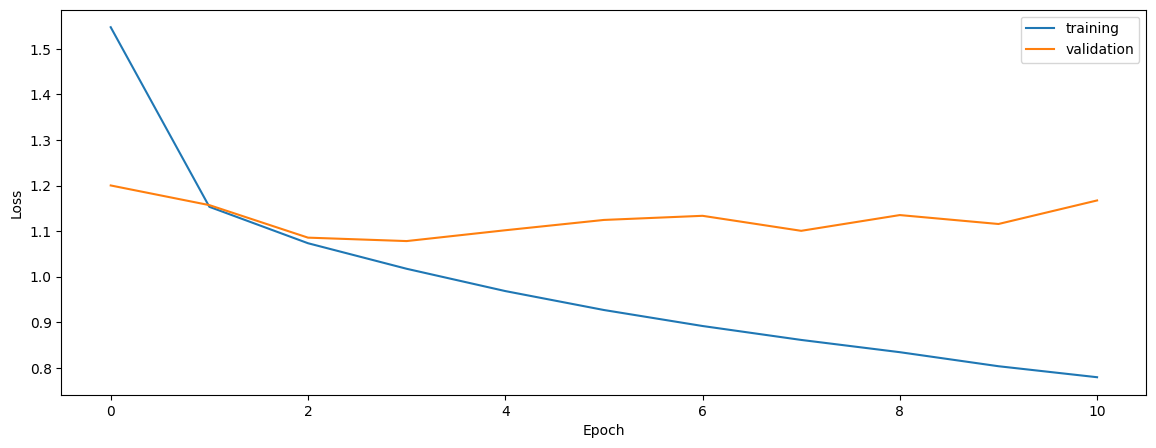

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6148029019593851
0.5630888463145612
0.5730882147350762


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5691510274164948
0.5597906987234427
0.5230554051615232


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5601225175377927
0.5369642522927195
0.5101140125045973


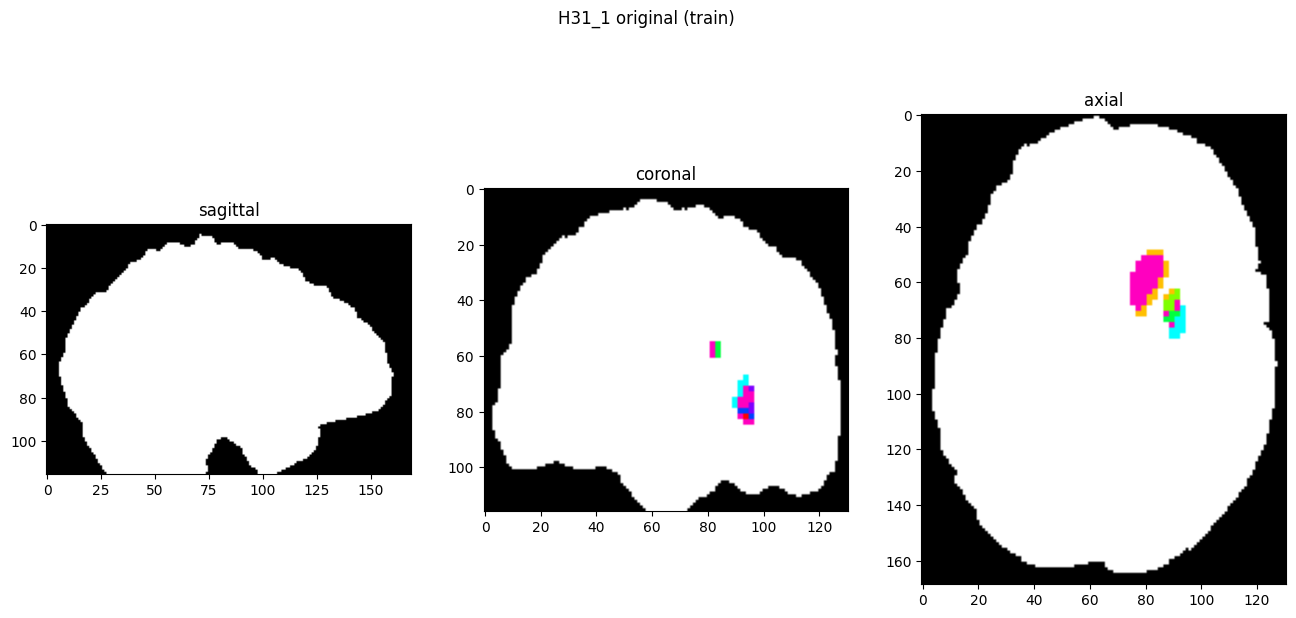

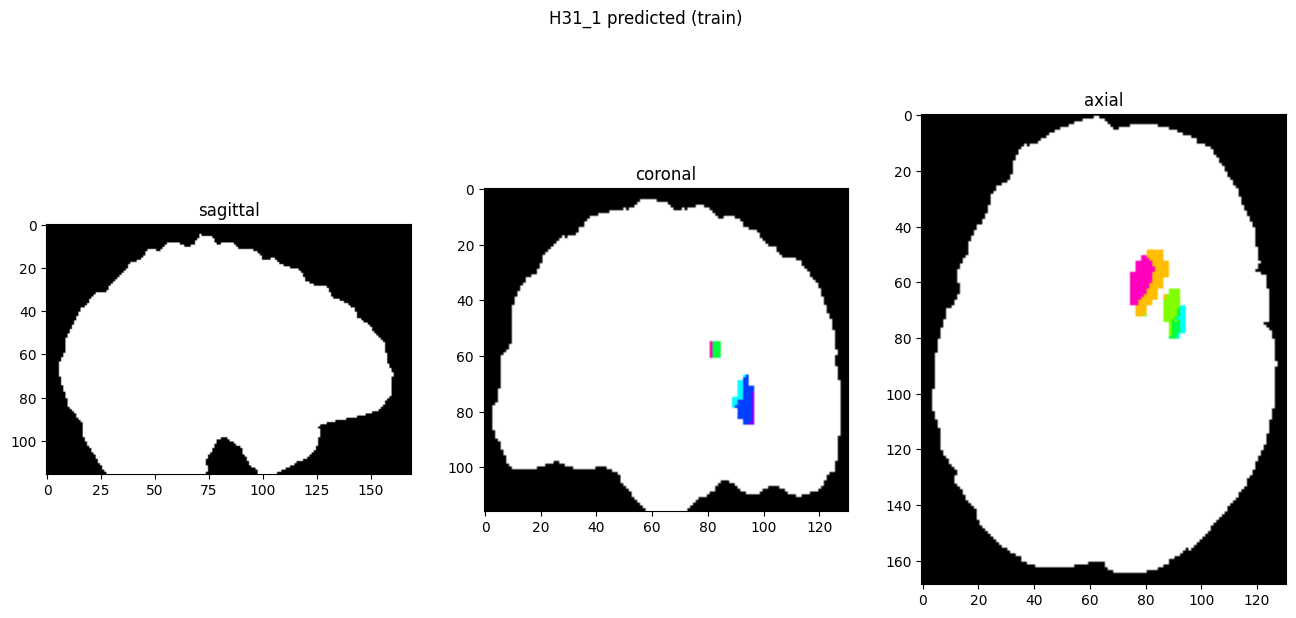

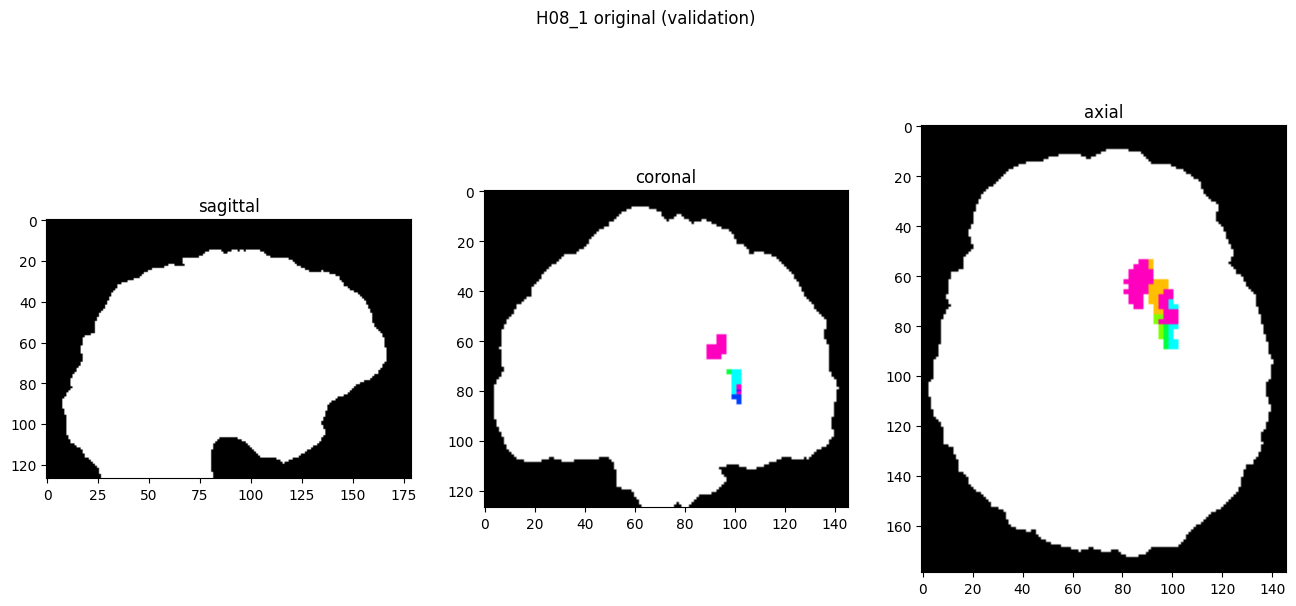

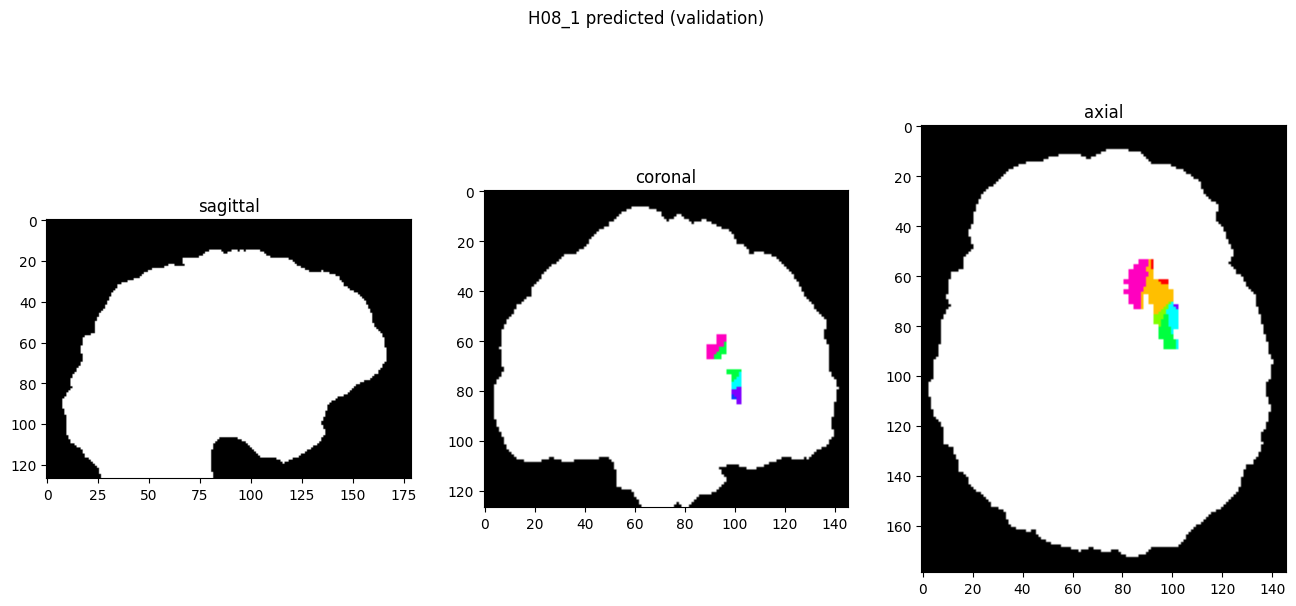

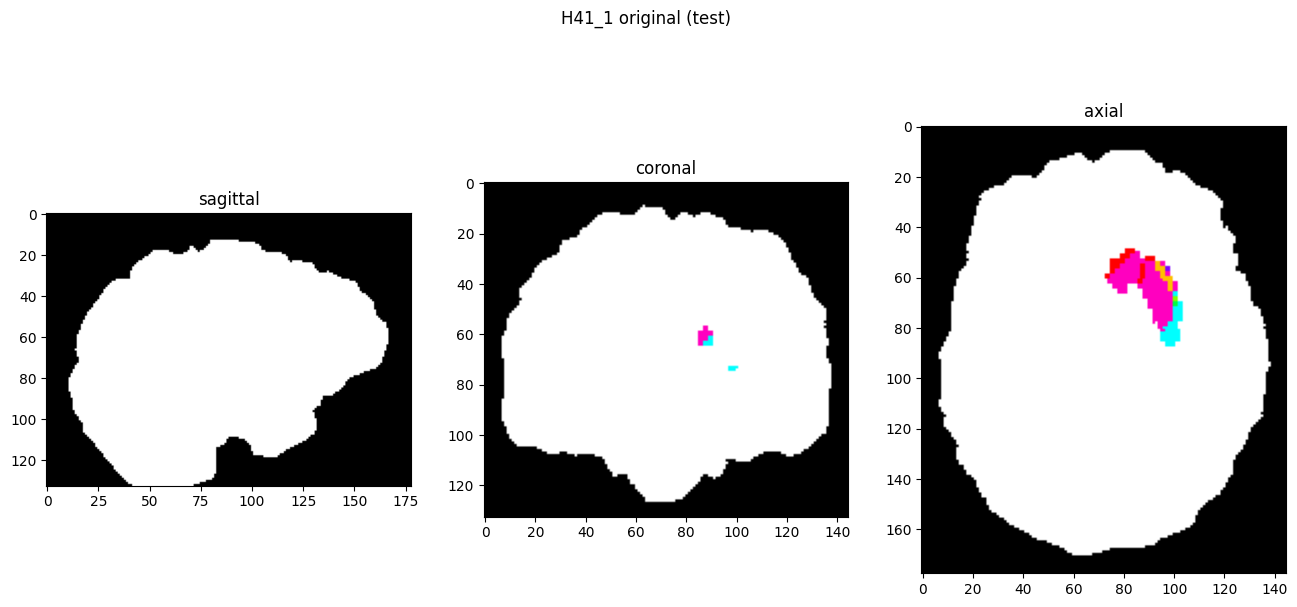

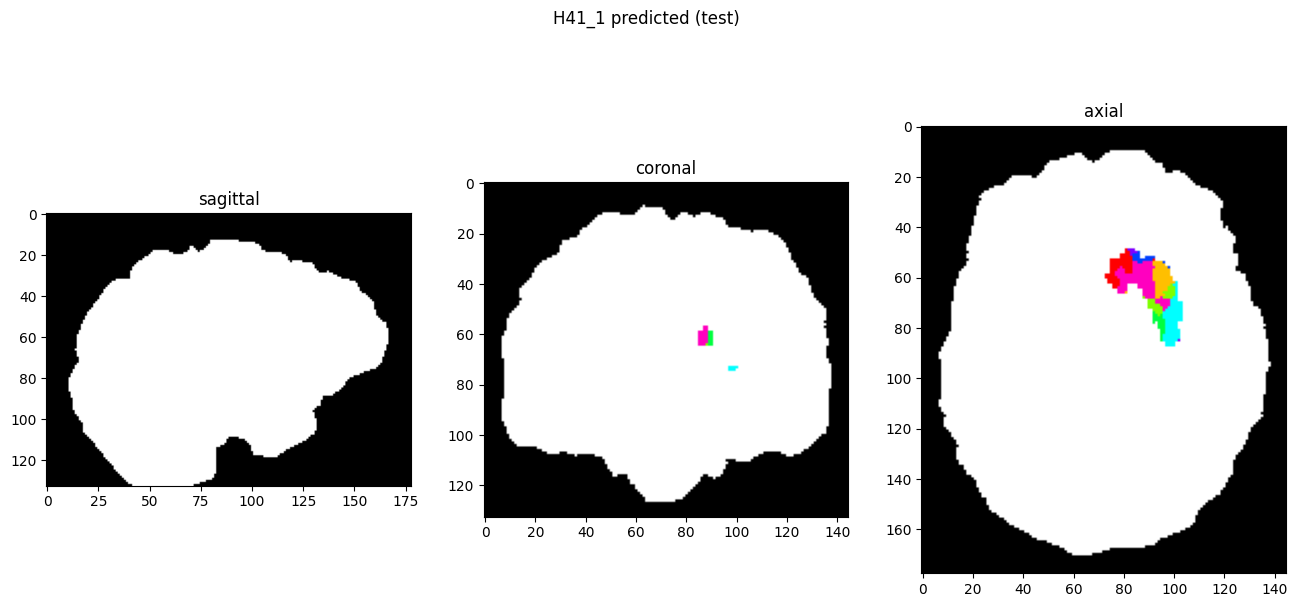

In [10]:
showResults(model, gen, threshold=0)